In [1]:
# # used a dictionary to represent an intents JSON file
# data = {"intents": [
# {"tag": "greeting",
#  "responses": ["Howdy Partner!", "  ", "How are you doing?",   "Greetings!", "How do you do?"]},
# {"tag": "age",
#  "responses": ["I am 25 years old", "I was born in 1998", "My birthday is July 3rd and I was born in 1998", "03/07/1998"]},
# {"tag": "date",
#  "responses": ["I am available all week", "I don't have any plans",  "I am not busy"]},
# {"tag": "name",
#  "responses": ["My name is James", "I'm James", "James"]},
# {"tag": "goodbye",
#  "responses": ["It was nice speaking to you", "See you later", "Speak soon!"]}
# ]}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
# specify GPU
device = torch.device("cuda")

In [5]:
# We have prepared a chitchat dataset with 5 labels
df = pd.read_excel("/content/drive/MyDrive/Chatbot using BERT and Pytorch/dataset.xlsx")
df.head()

,text,label
0,how far is your Friday,date
1,what do you want me to address you?,name
2,how is your day going so far,date
3,how is sunday going,date
4,I have sign off,goodbye


In [6]:
df['label'].value_counts()

greeting    5
name        4
goodbye     4
date        3
age         3
Name: label, dtype: int64

In [7]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
# check class distribution
df['label'].value_counts(normalize = True)

3    0.263158
4    0.210526
2    0.210526
1    0.157895
0    0.157895
Name: label, dtype: float64

In [8]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = df['text'], df['label']

In [9]:

train_labels

0     1
1     4
2     1
3     1
4     2
5     3
6     3
7     3
8     3
9     3
10    0
11    0
12    0
13    4
14    4
15    4
16    2
17    2
18    2
Name: label, dtype: int64

In [10]:
from transformers import AutoModel, BertTokenizerFast
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
from transformers import RobertaTokenizer, RobertaModel
# Load the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# Import Roberta pretrained model
bert = RobertaModel.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
from transformers import DistilBertTokenizer, DistilBertModel
# Load the DistilBert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Import the DistilBert pretrained model
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
text = ["this is a distil bert model.","data is oil"]
# Encode the text
encoded_input = tokenizer(text, padding=True,truncation=True, return_tensors='pt')
print(encoded_input)

# In input_ids:
# 101 - Indicates beginning of the sentence
# 102 - Indicates end of the sentence
# In attention_mask:
# 1 - Actual token
# 0 - Padded token

{'input_ids': tensor([[  101,  2023,  2003,  1037,  4487, 16643,  2140, 14324,  2944,  1012,
           102],
        [  101,  2951,  2003,  3514,   102,     0,     0,     0,     0,     0,
             0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]])}


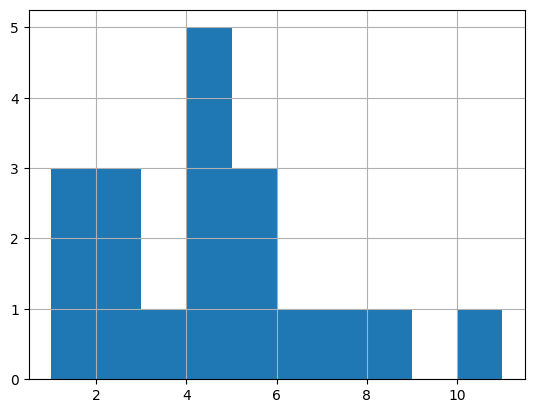

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)
# Based on the histogram we are selecting the max len as 8
max_seq_len = 8

In [15]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [16]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [18]:
class BERT_Arch(nn.Module):
   def __init__(self, bert):      
       super(BERT_Arch, self).__init__()
       self.bert = bert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,5)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.bert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [19]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in bert.parameters():
      param.requires_grad = False
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BERT_Arch                                               --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           1,285
├─LogSoftmax: 1-7                                       --
Total 

In [20]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_wts = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
print(class_wts)

[1.26666667 1.26666667 0.95       0.76       0.95      ]


In [22]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
# loss function
cross_entropy = nn.NLLLoss(weight=weights)

In [23]:
# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 200
# We can also use learning rate scheduler to achieve better results
lr_sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [24]:
# function to train the model
total_loss = 0.0123
def train():
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # clear calculated gradients
    optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
# compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
    
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
#returns the loss and predictions
  return avg_loss, total_preds

In [25]:
# start the
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 200

 Epoch 2 / 200

 Epoch 3 / 200

 Epoch 4 / 200

 Epoch 5 / 200

 Epoch 6 / 200

 Epoch 7 / 200

 Epoch 8 / 200

 Epoch 9 / 200

 Epoch 10 / 200

 Epoch 11 / 200

 Epoch 12 / 200

 Epoch 13 / 200

 Epoch 14 / 200

 Epoch 15 / 200

 Epoch 16 / 200

 Epoch 17 / 200

 Epoch 18 / 200

 Epoch 19 / 200

 Epoch 20 / 200

 Epoch 21 / 200

 Epoch 22 / 200

 Epoch 23 / 200

 Epoch 24 / 200

 Epoch 25 / 200

 Epoch 26 / 200

 Epoch 27 / 200

 Epoch 28 / 200

 Epoch 29 / 200

 Epoch 30 / 200

 Epoch 31 / 200

 Epoch 32 / 200

 Epoch 33 / 200

 Epoch 34 / 200

 Epoch 35 / 200

 Epoch 36 / 200

 Epoch 37 / 200

 Epoch 38 / 200

 Epoch 39 / 200

 Epoch 40 / 200

 Epoch 41 / 200

 Epoch 42 / 200

 Epoch 43 / 200

 Epoch 44 / 200

 Epoch 45 / 200

 Epoch 46 / 200

 Epoch 47 / 200

 Epoch 48 / 200

 Epoch 49 / 200

 Epoch 50 / 200

 Epoch 51 / 200

 Epoch 52 / 200

 Epoch 53 / 200

 Epoch 54 / 200

 Epoch 55 / 200

 Epoch 56 / 200

 Epoch 57 / 200

 Epoch 58 / 200

 Epoch 59 / 200

 Epoc

### Get Predictions for Test Data

In [26]:
def get_prediction(str):
 str = re.sub(r'[^a-zA-Z ]+', '', str)
 test_text = [str]
 model.eval()
 
 tokens_test_data = tokenizer(
 test_text,
 max_length = max_seq_len,
 pad_to_max_length=True,
 truncation=True,
 return_token_type_ids=False
 )
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print('Intent Identified: ', le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]
def get_response(message): 
  intent = get_prediction(message)
  for i in data['intents']: 
    if i["tag"] == intent:
      result = random.choice(i["responses"])
      break
  print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result

In [27]:
get_response('who are you' )

Intent Identified:  name
Response : James


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


'Intent: name\nResponse: James'